<h1><center>Image Stiching</center></h1>


<center>The goal of this project was to implement a program for creating a panoramic image from N partially overlapping images. Initially, detecting common keypoints between the images using the SIFT algorithm, computed the homography using the RANSAC method, and applied perspective transformations to align and stitch the images into a single panorama. Finally, experimenting with three different blending techniques to smoothly integrate the images and determine which one produced the best result.</center>

<h5><center>Import useful libraries</center></h5>

In [64]:
import cv2
import numpy as np
import os
import random
from matplotlib import pyplot as plt

<h5><center>Function to load images</center></h5>

In [66]:
def load_images_from_folder(folder):
    images = []
    for filename in sorted(os.listdir(folder)):
        path = os.path.join(folder, filename)
        if os.path.isfile(path):
            img = cv2.imread(path)
            if img is not None:
                images.append(img)
    return images

<h5><center>SIFT creation</center></h5>

In [68]:
sift = cv2.SIFT_create()

<h5><center>Homography Function</center></h5>

In [70]:
def compute_homography(p1, p2):
    A = []
    for i in range(len(p1)):
        x, y = p1[i]
        u, v = p2[i]
        A.append([-x, -y, -1, 0, 0, 0, x*u, y*u, u])
        A.append([0, 0, 0, -x, -y, -1, x*v, y*v, v])
    A = np.asarray(A)
    _, _, Vt = np.linalg.svd(A)
    H = Vt[-1].reshape(3,3)
    return H / H[-1,-1]

<h5><center>RANSAC usage</center></h5>

In [72]:
def ransac_homography(pts1, pts2, threshold=2.0, iterations=2000):
    max_inliers = []
    best_H = None
    num_pts = len(pts1)
    idx_all = list(range(num_pts))

    for _ in range(iterations):
        sample = random.sample(idx_all, 4)
        p1_s = pts1[sample]
        p2_s = pts2[sample]
        H_cand = compute_homography(p1_s, p2_s)

        # Project
        pts1_hom = np.hstack([pts1, np.ones((num_pts,1))])
        proj = (H_cand @ pts1_hom.T).T
        proj /= proj[:, [2]]

        errors = np.linalg.norm(proj[:,:2] - pts2, axis=1)
        inliers = errors < threshold
        if np.sum(inliers) > np.sum(max_inliers):
            max_inliers = inliers
            best_H = H_cand

    return best_H, max_inliers

<h5><center>Feather Blending</center></h5>

In [74]:
def feather_blend(base, overlay, mask_base, mask_overlay):
    base_f = base.astype(np.float32)
    over_f = overlay.astype(np.float32)

    dist_base = cv2.distanceTransform(mask_base, cv2.DIST_L2, 3)
    dist_over = cv2.distanceTransform(mask_overlay, cv2.DIST_L2, 3)
    dist_sum = dist_base + dist_over + 1e-5
    alpha = dist_base / dist_sum

    alpha_3 = np.dstack([alpha]*3)
    blended_overlap = base_f * alpha_3 + over_f*(1-alpha_3)
    blended_overlap = blended_overlap.astype(np.uint8)

    out = np.zeros_like(base)
    only_base = (mask_base==255)&(mask_overlay==0)
    only_over = (mask_overlay==255)&(mask_base==0)
    overlap = (mask_base==255)&(mask_overlay==255)

    out[only_base] = base[only_base]
    out[only_over] = overlay[only_over]
    out[overlap] = blended_overlap[overlap]
    return out

<h5><center>Linear Blending</center></h5>

In [76]:
def linear_blend(base, overlay, mask_base, mask_overlay):
    base_f = base.astype(np.float32)
    over_f = overlay.astype(np.float32)
    alpha = 0.5
    overlap = (mask_base==255)&(mask_overlay==255)
    only_base = (mask_base==255)&(mask_overlay==0)
    only_over = (mask_overlay==255)&(mask_base==0)

    out = np.zeros_like(base)
    out[only_base] = base[only_base]
    out[only_over] = overlay[only_over]

    blended_overlap = (alpha * base_f + (1-alpha)*over_f).astype(np.uint8)
    out[overlap] = blended_overlap[overlap]
    return out

<h5><center>Multiband Blending</center></h5>

In [78]:
def multiband_blend(base, overlay, mask_base, mask_overlay, num_bands=5):
    
    H = min(base.shape[0], overlay.shape[0])
    W = min(base.shape[1], overlay.shape[1])
    base = base[:H, :W]
    overlay = overlay[:H, :W]
    mask_base = mask_base[:H, :W]
    mask_overlay = mask_overlay[:H, :W]

    base_f = base.astype(np.float32)/255.0
    over_f = overlay.astype(np.float32)/255.0
    mb = mask_base.astype(np.float32)
    mo = mask_overlay.astype(np.float32)
    den = mb + mo + 1e-5
    frac = mb / den  # single-channel [0..1]

    #uild Gaussian pyramids
    gauss_base = [base_f]
    gauss_over = [over_f]
    gauss_frac = [frac]
    for _ in range(num_bands):
        gauss_base.append(cv2.pyrDown(gauss_base[-1]))
        gauss_over.append(cv2.pyrDown(gauss_over[-1]))
        gauss_frac.append(cv2.pyrDown(gauss_frac[-1]))

    #build Laplacian pyramids
    lap_base = []
    lap_over = []
    for i in range(num_bands):
        up_b = cv2.pyrUp(gauss_base[i+1], dstsize=(gauss_base[i].shape[1], gauss_base[i].shape[0]))
        lap_base.append(gauss_base[i] - up_b)
        up_o = cv2.pyrUp(gauss_over[i+1], dstsize=(gauss_over[i].shape[1], gauss_over[i].shape[0]))
        lap_over.append(gauss_over[i] - up_o)
    lap_base.append(gauss_base[-1])
    lap_over.append(gauss_over[-1])

    #blend each level using frac
    blended_pyr = []
    for i in range(num_bands+1):
        frac_i = gauss_frac[i]
        if len(frac_i.shape)==2:  
            frac_i = frac_i[..., None]
        if frac_i.shape[2]==1:
            frac_i = np.repeat(frac_i, 3, axis=2)

        lbase = lap_base[i]
        lover = lap_over[i]
        blend_lvl = lbase*frac_i + lover*(1-frac_i)
        blended_pyr.append(blend_lvl)

    blended = blended_pyr[-1]
    for i in range(num_bands-1, -1, -1):
        up_b = cv2.pyrUp(blended, dstsize=(blended_pyr[i].shape[1], blended_pyr[i].shape[0]))
        blended = blended_pyr[i] + up_b

    blended = np.clip(blended*255.0, 0, 255).astype(np.uint8)

    out = np.zeros_like(base, dtype=np.uint8)
    only_base = (mask_base==255)&(mask_overlay==0)
    only_over = (mask_overlay==255)&(mask_base==0)
    overlap = (mask_base==255)&(mask_overlay==255)
    out[only_base] = base[only_base]
    out[only_over] = overlay[only_over]
    out[overlap] = blended[overlap]
    return out

<h5><center>Customized Warp Function</center></h5>

In [80]:
def custom_warp_perspective(base_image, next_image, H, blend_method="feather"):
    h1, w1 = base_image.shape[:2]
    h2, w2 = next_image.shape[:2]

    corners1 = np.float32([[0,0],[0,h1],[w1,h1],[w1,0]]).reshape(-1,1,2)
    corners2 = np.float32([[0,0],[0,h2],[w2,h2],[w2,0]]).reshape(-1,1,2)
    warped_corners = cv2.perspectiveTransform(corners1, H)
    all_corners = np.concatenate((warped_corners, corners2), axis=0)

    [x_min, y_min] = np.int32(all_corners.min(axis=0).ravel() - 0.5)
    [x_max, y_max] = np.int32(all_corners.max(axis=0).ravel() + 0.5)

    trans = [-x_min, -y_min]
    T = np.array([[1,0,trans[0]],[0,1,trans[1]],[0,0,1]], dtype=np.float32)

    panorama = cv2.warpPerspective(base_image, T@H, (x_max - x_min, y_max - y_min))

    overlay = np.zeros_like(panorama)
    overlay[trans[1]:trans[1]+h2, trans[0]:trans[0]+w2] = next_image

    mask_base = (panorama.sum(axis=2)>0).astype(np.uint8)*255
    mask_over = (overlay.sum(axis=2)>0).astype(np.uint8)*255

    if blend_method=="feather":
        blended = feather_blend(panorama, overlay, mask_base, mask_over)
    elif blend_method=="linear":
        blended = linear_blend(panorama, overlay, mask_base, mask_over)
    elif blend_method=="multiband":
        blended = multiband_blend(panorama, overlay, mask_base, mask_over, num_bands=5)
    else:
        print(f"[WARN] Unknown blend method '{blend_method}'. Defaulting to feather.")
        blended = feather_blend(panorama, overlay, mask_base, mask_over)

    return blended

<h5><center>Stiching Fuction</center></h5>

In [82]:
def stitch_images(images, blend_method="feather"):
    panorama = images[0]
    for i in range(1, len(images)):
        gray1 = cv2.cvtColor(panorama, cv2.COLOR_BGR2GRAY)
        gray2 = cv2.cvtColor(images[i], cv2.COLOR_BGR2GRAY)

        kpts1, desc1 = sift.detectAndCompute(gray1, None)
        kpts2, desc2 = sift.detectAndCompute(gray2, None)
        bf = cv2.BFMatcher()
        matches = bf.knnMatch(desc1, desc2, k=2)

        good = []
        for m,n in matches:
            if m.distance < 0.75*n.distance:
                good.append(m)
        if len(good)<4:
            print("[WARN] Not enough matches for image", i)
            continue

        pts1 = np.float32([kpts1[m.queryIdx].pt for m in good])
        pts2 = np.float32([kpts2[m.trainIdx].pt for m in good])

        H, _ = ransac_homography(pts1, pts2, threshold=3, iterations=2000)
        panorama = custom_warp_perspective(panorama, images[i], H, blend_method=blend_method)

    return panorama

<h5><center>Main Function</center></h5>

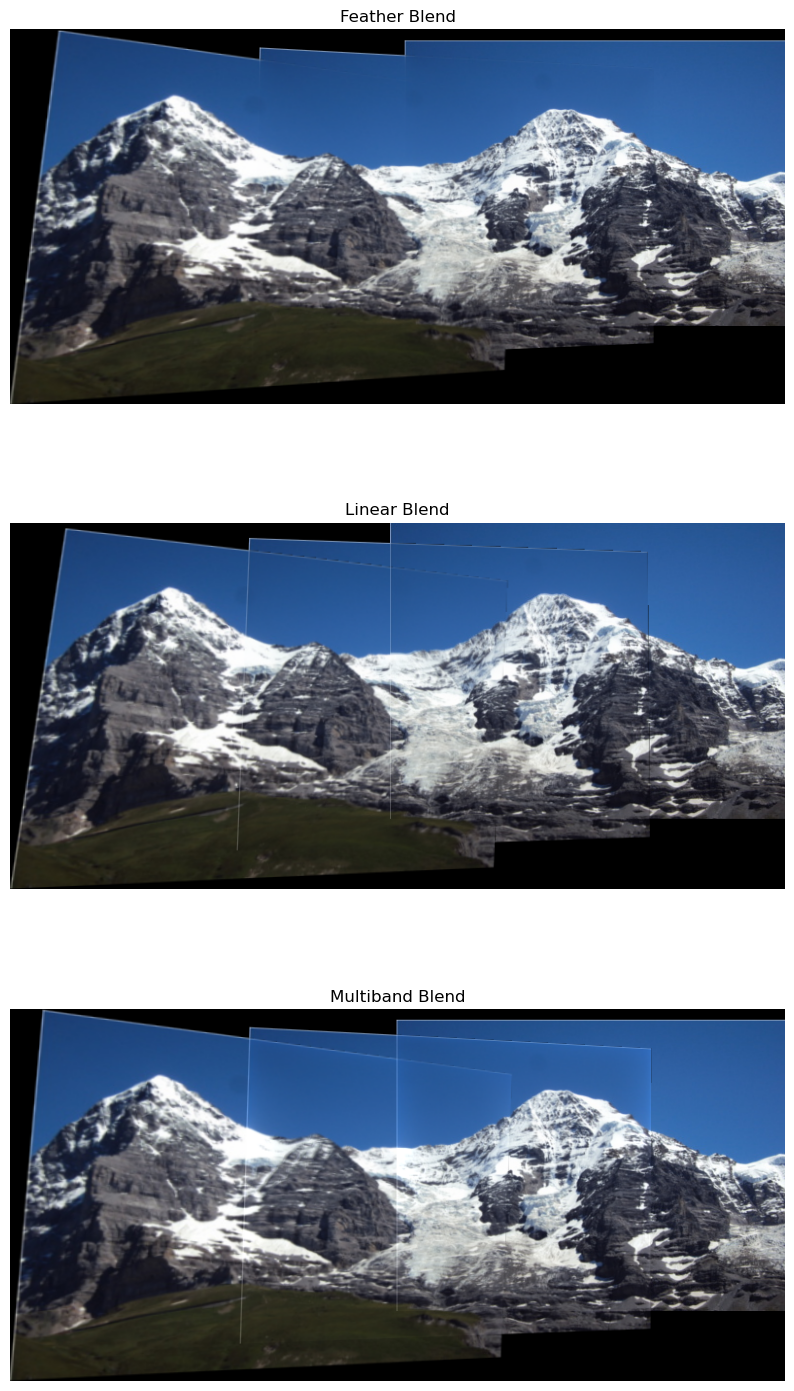

In [84]:
if __name__=="__main__":
    folder = "images" 
    images = load_images_from_folder(folder)
    
    stitched_feather = stitch_images(images, blend_method="feather")
    stitched_linear = stitch_images(images, blend_method="linear")
    stitched_multiband = stitch_images(images, blend_method="multiband")

    plt.figure(figsize=(10, 18))  

    plt.subplot(3, 1, 1)  
    plt.imshow(cv2.cvtColor(stitched_feather, cv2.COLOR_BGR2RGB))
    plt.title("Feather Blend")
    plt.axis('off')

    plt.subplot(3, 1, 2) 
    plt.imshow(cv2.cvtColor(stitched_linear, cv2.COLOR_BGR2RGB))
    plt.title("Linear Blend")
    plt.axis('off')

    plt.subplot(3, 1, 3)  
    plt.imshow(cv2.cvtColor(stitched_multiband, cv2.COLOR_BGR2RGB))
    plt.title("Multiband Blend")
    plt.axis('off')

    plt.show()